# Welcome to the final project!
In this notebook you will be asked to use singular value decomposition and SVM to classify images. We will be working with the MNIST numbers dataset, where training data consist of pictures of digits, and the target value is the digit itself.

First, we import the necessary libraries.

In [1]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

Now, we read both training and test dataset as arrays. 

In [2]:
### training data consist of pictures of digits, and the target value is the digit itself.

data = np.load('mnist.npz')
X_test_total, X_train_total, y_train_total, y_test_total = data['x_test'], data['x_train'], data['y_train'], data['y_test']



Let's select two digits that we will be learning to separate, for example 3 and 8.

In [3]:
num1, num2 = 3, 8

Let us form the lists of indices i such that the target of i-th object of our training data is either num1 or num2. Do the same for the test dataset.

In [4]:
train_indx = [y == num1 or y == num2 for y in y_train_total] 

#test_indx = # your code here
test_indx = [y == num1 or y == num2 for y in y_test_total] 

Form new arrays consisting of the data with the target values num1 and num2 only. 

In [5]:
X_train, y_train = X_train_total[train_indx], y_train_total[train_indx]
#X_test, y_test = # your code here

X_test, y_test = X_test_total[test_indx], y_test_total[test_indx]

The following two cells ensure automatic grading.

In [8]:
import sys
sys.path.append("..")

import grading
grader = grading.Grader(assignment_key="5QcKcr06RZWNXOR6ZubzOg", 
                      all_parts=["EGrPV", "LtYil", "otUqA", "o4nIb", "rZkTW", "keYiw"])

In [9]:
# token expires every 30 min
COURSERA_TOKEN = "OrPEbhGpte12t1Gj"
COURSERA_EMAIL = "arnautoleg1@gmail.com"

## Looking at the data

Let us check the sizes of the datasets and the shape of one image.

In [10]:
print('Data shapes: ')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

Data shapes: 
X_train:  (11982, 28, 28)
y_train:  (11982,)
X_test:  (1984, 28, 28)
y_test:  (1984,)


In [12]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]

n_train, n_test

(11982, 1984)

In [13]:
print('Shape of one item: ')
print(X_train[0].shape)

X_train

Shape of one item: 
(28, 28)


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ..., 
       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, 

Train data are images of digits.

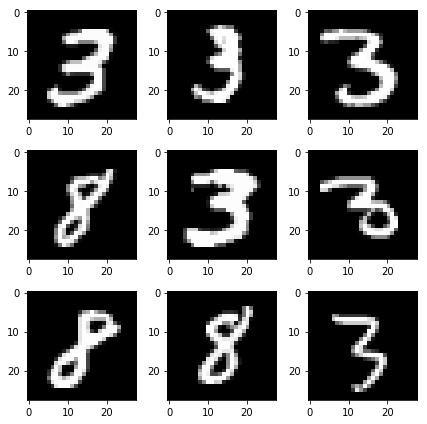

In [14]:
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    plt.imshow(X_train[i], cmap='gray')
plt.tight_layout()
plt.show()

Target values are numbers.

In [15]:
y_train[:9]

array([3, 3, 3, 8, 3, 3, 8, 8, 3], dtype=uint8)

## Task 1 (1 point)
Now our data is 3-dimensional of shape (number of images, n_pixels, n_pixels). To work with PCA and SVM we need to flatten the images by turning each of them into an array of shape (n_pixels x n_pixels, ).

In [16]:
def flatten_image(X):
    return X.reshape(X.shape[0]*X.shape[0]).T
    

In [21]:
X_train_flat = np.array([flatten_image(img) for img in X_train])
X_test_flat = np.array([flatten_image(img) for img in X_test])
print(X_test_flat.shape, X_train_flat.shape)

(1984, 784) (11982, 784)


((1984, 784), (11982, 784))

PCA works best when the data is scaled (think, why?), so let's scale our data. We will use [StandartScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for it. Note, that scaling replaces a collection of vectors x by the collection of the vectors $x' = (x-M)/D$, where $M$ is the mean vector of
the sample, $D$ is the vector of standard deviations of all components of the vectors, and the division is component-wise. So, the scaled collection has the same size as the original one, and each column has 0 mean and unit standard deviation.


In [22]:
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

## Question 1

Please write your answer on the impact of scaling below. Why does scaling help PCA? If your idea need some computer experiments for confirmation (say, training and accuracy calculations  with non-scaled data), please provide the code here as well.

***Your answer here.***

In [0]:
#your code here

Now, we call PCA and reduce the number of components for each vector. 

In [23]:
pca = PCA(n_components=128, random_state=42)
X_train_flat = pca.fit_transform(X_train_flat)

In [24]:
X_test_flat = pca.transform(X_test_flat)

In [25]:
X_test_flat.shape, X_test_flat.shape

((1984, 128), (1984, 128))

## Question 2

What is the ratio of the memory used for the data `compressed' by PCA and the one used for the original data?

***Your answer here.***

Now, we use SVM with linear kernel to separate the two classes.

In [26]:
%%time
clf = LinearSVC(random_state=42)
clf.fit(X_train_flat, y_train) 

CPU times: user 2.68 s, sys: 154 ms, total: 2.84 s
Wall time: 2.84 s


Now, let us make the predictions and calculate the accuracy, that is, the ratio of the true predictions to the test sample size.  Use [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) as the quality metric here.

$$accuracy(y\_true, y\_pred) = \frac{1}{n}\sum_{i=1}^n [y\_true_i=y\_pred_i],$$ where $[a=b]=1$, if $a=b$, and $0$ otherwise.

In [29]:
y_true = y_train
y_pred = clf.predict(X_train_flat)
acc = accuracy_score(y_true, y_pred)
print("Test accuracy: ", acc)

Test accuracy:  0.967951927892


In [30]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("EGrPV", acc)

In [31]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## Try it from your own input
Try to make your own dataset. You can either make a photo image of an ink-written digit or draw a digit using a graphical editor of your computer or smartphone. Note that the input picture has to be a white number on a black background, like the numbers in the MNIST dataset. It can be either in png or jpeg format. Replace the sample striwith your file name. 

In [32]:
from scipy import misc
from PIL import Image

In [1]:
image = Image.open('8_versus_3.npg').convert('L')
new_image = image.resize((28, 28))
custom = np.array(new_image)
custom.shape

NameError: name 'Image' is not defined

In [2]:
plt.imshow(custom, cmap='gray')
plt.show()

NameError: name 'plt' is not defined

Re-shape your image and make a prediction. 

In [3]:
custom = flatten_image(custom).reshape(1, -1)
custom = scaler.transform(custom)
custom = pca.transform(custom)
custom.shape

NameError: name 'flatten_image' is not defined

In [ ]:
clf.predict(custom)

## Question 3

Repeat the above digit recognition procedure with other 5 to 10 hand-written images. Do your experiments confirm the above accuracy estimate? How do you think, why they confirm (or not confirm) it?

***Your answer here.***

## Task 2
Now let's try another approach explained [here](https://intranet.math.vt.edu/ugresearch/Lassiter_2012_2013.pdf) in Section 3. For each digit, we create a new matrix $A$ whose columns are flattened images of this digit. The first several (say, 10) columns of the matrix $U$ from SVD decomposition of $A$ represent a collection of "typical" images of this digit. Given an unrecognized flatten image, among average typical flattened images we find the closets one. Its target value is considered as a prediction for the target of the unrecognized image.

## SVD refesher
As you may recall from the lectures, SVD of a matrix $A$ is a decomposition:
$A = U \Sigma V^T,$ where $U$ and $V$ are orthogonal matrices. In this method we will be utilizing some properties of SVD.
Please note that due to large shapes of matrices the operations might take a while.

In [0]:
def getSingularVectorsLeft(matrix, number=10): # let's take first 10 numbers
    # return first _number_ columns of U from SVD of _matrix_

In [0]:
def getSingularImage(X_train, y_train, number):
    # find images whose target is _number_
    for image in select_images:
    # iteratively append new column to form matrix A


    # left_basis = # get left singular vectors

    return left_basis

Try it first on "0".

In [0]:
left_basis = getSingularImage(X_train_total, y_train_total, 0)

assert left_basis.shape, (784, 10)

### Task 2.1 (1 point)
Plot first 9 singular images of the digit 0 taking columns of matrix U and reshaping them back into images 28x28. Use `numpy.reshape`.

In [43]:
#singular images
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    img = # ith element of left basis reshaped back to 28x28
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (<ipython-input-43-4d4379bc2632>, line 6)

In [0]:
## GRADED PART, DO NOT CHANGE!
#9th image will be graded:
grader.set_answer("LtYil", img[:, 5:7].flatten())

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

## Question 4

Reflect on properties of the columns of $U_k$. What properties do you think are contained in each of them? Draw more singular images to help you make conclusions.

***Your answer here.***

Now let's move on and obtain singular images for all numbers. The matrices $U_k$ from  [the article](https://intranet.math.vt.edu/ugresearch/Lassiter_2012_2013.pdf) are represented as `number_basis_matrices[k]`.
This might take a while to finish, feel free to add debug print in your function to know the progress.

In [0]:
number_basis_matrices = # use getSingularImage funciton to get matrices for all numbers

### Task 2.2 (1 point)
Plot the first singular image of each digit, similarly to the previous task.

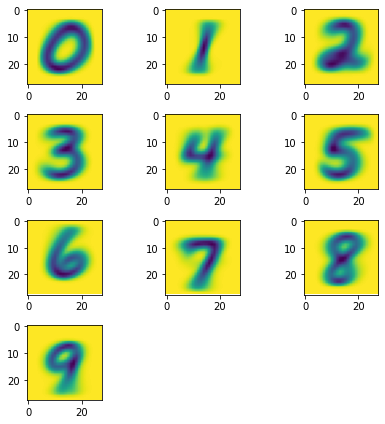

In [0]:
plt.figure(figsize=(6,6))
a, b = 3, 4
for i in range(10):  
    plt.subplot(b, a, i+1)
    img = # first column of U_k in number_basis_matrices[i] reshaped into 28x28 image
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

In [0]:
## GRADED PART, DO NOT CHANGE!
#last image (of digit 9) will be graded:
grader.set_answer("otUqA", img[:, 5:7].flatten())

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

In [0]:
dim = number_basis_matrices[0].shape[0]

784

### Task 2.3 (1.5 points)

Here we calculate the new projection matrix for each $U_k$ to apply later in testing:
$pr = (I - U_k \cdot U_{k}^{T})$. Use `numpy.matmul` for matrix multiplication and `numpy.identity` to create an identity matrix. Please note that this operation might also take some time to finish.

In [0]:
numeric_values = # create an array of pr for each number

In [0]:
## GRADED PART, DO NOT CHANGE!
k = np.array([n[3:5, 3:13] for n in numeric_values])
grader.set_answer("o4nIb", k.flatten())

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

### Task 2.4 (1.5 points)
Implement function utilizing `numeric_values` matrices to predict labels for unknown images. Use `numpy.norm` and enumerate to iterate over numeric values.

In [0]:
def find_closest(test_value, numeric_values):
    stacked_test = test_value.reshape(-1, 1)
    # find closest U_k to test_value using norm and return the target digit

    return target

In [0]:
y_pred = # find array of predictions for test values and calculate accuracy in the cell below

In [0]:
acc = accuracy_score(y_test, y_pred)

In [0]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("rZkTW", acc)

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

## Additional task (2 points)
In the first task we trained Linear SVM to separate 3s and 8s. Here you can implement multiclass classification for _all_ numbers in `MNIST`. Use the same function LinearSVC for “one-vs-the-rest” multi-class strategy, see [the documentation](https://scikit-learn.org/stable/modules/svm.html#classification).  Follow the same steps from task 1: scaling, feature selection, training and testing. Is the accuracy of this method greater then the one calculated above?

**Note:** Use `random_state=42` for `PCA` and `LinearSVC`. Training `LinearSVC` on all the data might take a while, that's normal.

In [0]:
# flatten
# Scandart Scaler
# PCA
# LinearSVC

In [0]:
acc = # calculate accuracy

In [0]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("keYiw", acc)

In [ ]:
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)